## Exemplo


In [31]:
import pandas as pd
import numpy as np
import pywt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 1. Carregar os dados
df = pd.read_csv("../../dataset2001_2024.csv")

# 2. Substituir valores inválidos (-999) por NaN
df.replace(-999.0, 0, inplace=True)

# 3. Criar a coluna de data a partir de YEAR, MO, DY e HR
df.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'}, inplace=True)
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)


In [32]:
# 4. Criar Lags para a variável 'T2M' (exemplo com lags de 1 a 5 horas)
for lag in range(1, 6):  # Lags de 1 a 5 horas
    df[f'T2M_lag_{lag}'] = df['T2M'].shift(lag)


# 5. Separar dados até 2022 para treino e dados de 2023 para teste
train = df[df['datetime'].dt.year < 2023]
test = df[df['datetime'].dt.year == 2023]

In [33]:
# 6. Definir as variáveis independentes (X) e dependentes (y)
X_train = train.drop(columns=['T2M', 'datetime'])
y_train = train['T2M']
X_test = test.drop(columns=['T2M', 'datetime'])
y_test = test['T2M']

# 7. Função para aplicar DWT (Transformada Discreta de Wavelet)
def apply_dwt(series, wavelet='db1', level=1):
    """
    Aplica a DWT à série temporal e retorna os coeficientes de aproximação e detalhe.
    """
    # Decomposição DWT
    coeffs = pywt.wavedec(series, wavelet, level=level)
    
    # A função wavedec retorna uma lista de coeficientes [Aprox, Detalhes]
    # Usaremos a aproximação (coeficiente de nível mais alto) e os detalhes (coeficientes de nível inferior)
    return coeffs

# 8. Aplicar DWT nas variáveis de interesse (neste caso, T2M)
def apply_dwt_features(df, wavelet='db1', level=1):
    """
    Aplica DWT em todas as colunas numéricas e retorna uma matriz com as novas características.
    """
    dwt_features = []
    
    # Aplicar DWT para cada variável numérica
    for col in df.select_dtypes(include=np.number).columns:
        if col != 'T2M':  # Não aplicar em T2M diretamente
            coeffs = apply_dwt(df[col], wavelet=wavelet, level=level)
            # Usar a aproximação (primeiro coeficiente) e os detalhes (coeficientes subsequentes)
            features = np.concatenate([coeffs[0], *coeffs[1:]])
            dwt_features.append(features)
    
    # Retornar a matriz de características DWT
    return np.array(dwt_features).T




In [34]:
# 9. Aplicar DWT para extrair características temporais
X_train_dwt = apply_dwt_features(X_train)
X_test_dwt = apply_dwt_features(X_test)

# 10. Treinamento do modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_dwt, y_train)

# 11. Previsão para 2023
y_pred = rf.predict(X_test_dwt)

# 12. Avaliação do modelo (MAE - Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")



Mean Absolute Error: 4.451848789954338


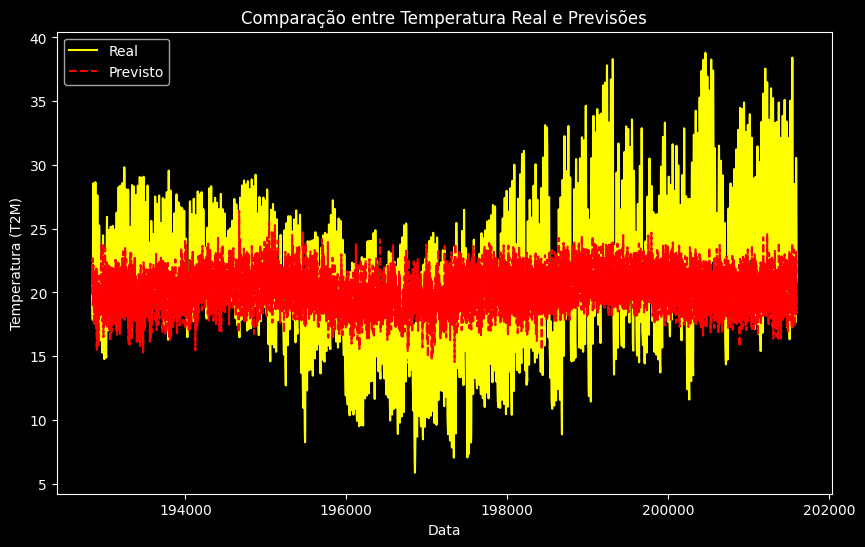

In [35]:
# 13. Visualização de uma comparação entre valores reais e previstos (opcional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Real", color='yellow')
plt.plot(y_test.index, y_pred, label="Previsto", linestyle='--', color='red')
plt.xlabel('Data')
plt.ylabel('Temperatura (T2M)')
plt.title('Comparação entre Temperatura Real e Previsões')
plt.legend()
plt.show()

### Comparando com o RF sem DWT

In [36]:
# 10. Treinamento do modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 11. Previsão para 2023
y_pred_2 = rf.predict(X_test)

# 12. Avaliação do modelo (MAE - Mean Absolute Error)
mae_2 = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae_2}")

Mean Absolute Error: 4.451848789954338


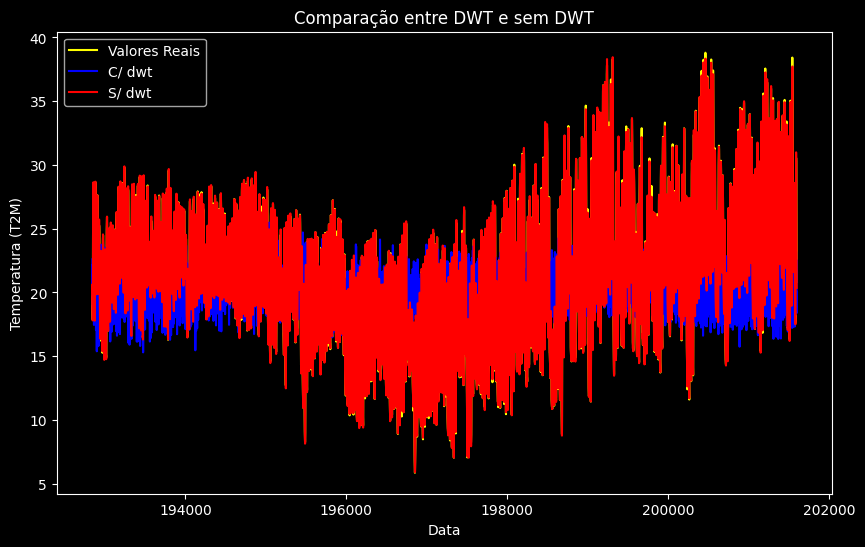

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores Reais', color='yellow')
plt.plot(y_test.index, y_pred, label="C/ dwt", color='blue')
plt.plot(y_test.index, y_pred_2, label="S/ dwt", color='red')
plt.xlabel('Data')
plt.ylabel('Temperatura (T2M)')
plt.title('Comparação entre DWT e sem DWT')
plt.legend()
plt.show()